In [1]:
import umap
import time
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from src.preprocessing import CustomDataGenerator
from src.dataloader import read_train, read_val

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-28 22:03:57.787756: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 22:03:57.980696: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 22:03:58.575261: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not f

In [2]:

X_train, y_train = read_train()
X_val, y_val = read_val()

In [3]:
import keras
from src import config
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
# set cpu as available physical device
import tensorflow as tf

INPUT_SHAPE = (config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS)
model = keras.applications.EfficientNetB0(weights="imagenet", 
                                 include_top=True)

extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
resize_layer = keras.layers.Resizing(224, 224, interpolation='bilinear', name='resize')
preprocess_input_layer = keras.layers.Lambda(preprocess_input, name='preprocess_input')
extractor = keras.Sequential([
    resize_layer,
    preprocess_input_layer,
    extractor
])

extractor(X_train[:1])
extractor.summary()

2023-11-28 22:04:18.049711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 22:04:18.108242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 22:04:18.108346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resize (Resizing)           (1, 224, 224, 3)          0         
                                                                 
 preprocess_input (Lambda)   (1, 224, 224, 3)          0         
                                                                 
 model (Functional)          (None, 1280)              4049571   
                                                                 
Total params: 4049571 (15.45 MB)
Trainable params: 4007548 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


2023-11-28 22:04:19.631169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [3]:
import umap

def get_features(X, y, extractor):
    loader = CustomDataGenerator(X, y, batch_size=32)
    features = extractor.predict(loader)
    return features

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
X_train_features = get_features(X_train, y_train, extractor)
X_val_features = get_features(X_val, y_val, extractor)

46/46 [==============================] - 2s 35ms/step


In [ ]:
# from sklearn.svm import LinearSVC
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# umap = umap.UMAP(n_components=8, random_state=42)
# svc = LinearSVC(random_state=42, max_iter=10000)
# pipe = Pipeline([
#     ('scaler', StandardScaler()),
#     ('umap', umap),
#     ('svc', svc)
# ])

# %%time
# print("Fitting pipeline...")
# pipe.fit(X_train_features, y_train)

In [ ]:
# y_pred_train = pipe.predict(X_train_features)
# y_pred_val = pipe.predict(X_val_features)

# from sklearn.metrics import accuracy_score
# print("Train accuracy:", accuracy_score(y_train, y_pred_train))
# print("Val accuracy:", accuracy_score(y_val, y_pred_val))

Train accuracy: 0.8656650246305418
Val accuracy: 0.623448275862069


In [7]:
ls_n_features = [2, 4, 8, 16, 32, 64, 128]
ls_train_acc = []
ls_val_acc = []
ls_time = []

for n_features in ls_n_features:
    print(f"Number of Features: {n_features}")
    t0 = time.time()
    umap_pipe = umap.UMAP(n_components=n_features)
    svc = LinearSVC(random_state=42, max_iter=10000)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('umap', umap_pipe),
        ('svc', svc)
    ])

    print("Fitting pipeline...")
    pipe.fit(X_train_features, y_train)

    print("Predicting...")
    y_pred_train = pipe.predict(X_train_features)
    y_pred_val = pipe.predict(X_val_features)

    print("Calculating accuracy...")
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)

    ls_train_acc.append(train_acc)
    ls_val_acc.append(val_acc)
    ls_time.append(time.time() - t0)

    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Val accuracy: {val_acc:.4f}")
    print(f"Time: {ls_time[-1]:.2f}s")
    print()

    

Number of Features: 2
Fitting pipeline...


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Predicting...
Calculating accuracy...
Train accuracy: 0.2766
Val accuracy: 0.2124
Time: 70.72s

Number of Features: 4
Fitting pipeline...


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Predicting...
Calculating accuracy...
Train accuracy: 0.7642
Val accuracy: 0.5469
Time: 42.56s

Number of Features: 8
Fitting pipeline...


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Predicting...
Calculating accuracy...
Train accuracy: 0.8697
Val accuracy: 0.6214
Time: 38.06s

Number of Features: 16
Fitting pipeline...


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Predicting...
Calculating accuracy...
Train accuracy: 0.8839
Val accuracy: 0.6324
Time: 50.47s

Number of Features: 32
Fitting pipeline...


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Predicting...
Calculating accuracy...
Train accuracy: 0.7152
Val accuracy: 0.5090
Time: 68.38s

Number of Features: 64
Fitting pipeline...


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Predicting...
Calculating accuracy...
Train accuracy: 0.8307
Val accuracy: 0.5897
Time: 141.75s

Number of Features: 128
Fitting pipeline...


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Predicting...
Calculating accuracy...
Train accuracy: 0.8011
Val accuracy: 0.5552
Time: 383.03s



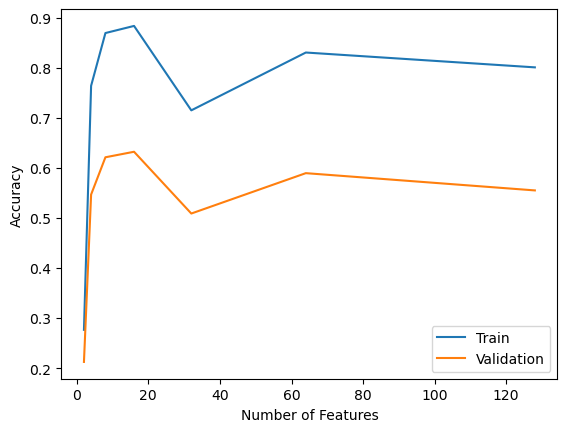

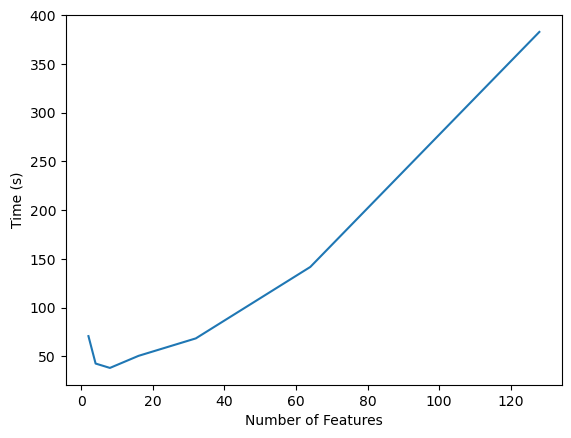

In [8]:
# Plot results
import matplotlib.pyplot as plt
plt.plot(ls_n_features, ls_train_acc, label="Train")
plt.plot(ls_n_features, ls_val_acc, label="Validation")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(ls_n_features, ls_time)
plt.xlabel("Number of Features")
plt.ylabel("Time (s)")
plt.show()

In [24]:
umap_pipe = umap.UMAP(n_components=16)
svc = LinearSVC(random_state=42, max_iter=10000)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap_pipe),
    ('svc', svc)
])

print("Fitting pipeline...")
pipe.fit(X_train_features, y_train)

print("Predicting...")
y_pred_train = pipe.predict(X_train_features)
y_pred_val = pipe.predict(X_val_features)

print("Calculating accuracy...")
train_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)

Fitting pipeline...


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Predicting...
Calculating accuracy...


In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
umap_pipe = umap.UMAP(n_components=16)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap_pipe),
    ('rf', rf)
])

print("Fitting pipeline...")
pipe.fit(X_train_features, y_train)

print("Predicting...")
y_pred_train = pipe.predict(X_train_features)
y_pred_val = pipe.predict(X_val_features)

print("Calculating accuracy...")
train_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)

Fitting pipeline...
Predicting...
Calculating accuracy...


In [29]:
train_acc, val_acc

(0.9999507389162562, 0.6537931034482759)

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=5)
umap_pipe = umap.UMAP(n_components=16)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap_pipe),
    ('rf', rf)
])

print("Fitting pipeline...")
pipe.fit(X_train_features, y_train)

print("Predicting...")
y_pred_train = pipe.predict(X_train_features)
y_pred_val = pipe.predict(X_val_features)

print("Calculating accuracy...")
train_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)

Fitting pipeline...
Predicting...
Calculating accuracy...


In [35]:
train_acc, val_acc

(0.9628571428571429, 0.6558620689655172)

In [36]:
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf = RandomForestClassifier(random_state=42)
umap_pipe = umap.UMAP(n_components=16)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap_pipe),
    ('rf', rf)
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__min_samples_leaf': [1, 5, 10],
    # 'umap__n_components': [2, 4, 8, 16, 32, 64, 128]
}

grid = GridSearchCV(pipe, param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train_features, y_train)

best_params = grid.best_params_

df_results = pd.DataFrame(grid.cv_results_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


2023-11-28 22:01:46.091127: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 22:01:46.117649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 22:01:46.155089: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 22:01:46.161069: I tensorflow/core/util/port.cc:110] oneDNN custom operations ar